In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Helper functions

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    return summary

## Function to reduce the DF size from https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
df_train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df_train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
df_test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
sample_submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

In [5]:
df_train = pd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='left')
df_test = pd.merge(df_test_transaction, df_test_identity, on='TransactionID', how='left')

del df_train_transaction, df_train_identity, df_test_transaction, df_test_identity

In [6]:
resumetable(df_train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,TransactionID,int64,0,590540,2987000,2987001,2987002
1,isFraud,int64,0,2,0,0,0
2,TransactionDT,int64,0,573349,86400,86401,86469
3,TransactionAmt,float64,0,20902,68.5,29,59
4,ProductCD,object,0,5,W,W,W
5,card1,int64,0,13553,13926,2755,4663
6,card2,float64,8933,500,NaN,404,490
7,card3,float64,1565,114,150,150,150
8,card4,object,1577,4,discover,mastercard,visa
9,card5,float64,4259,119,142,102,166


In [7]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 670.48 Mb (66.1% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [8]:
df_train.dtypes.value_counts()

float16    354
float32     45
object      31
int32        2
int16        1
int8         1
dtype: int64

There are 31 columns with 'object' type. We will need to perform label encoding later.

In [9]:
df_train['isFraud'].describe()

count    590540.000000
mean          0.034990
std           0.183755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

About 3.5% of the transactions in the training data are marked as fraudulent.

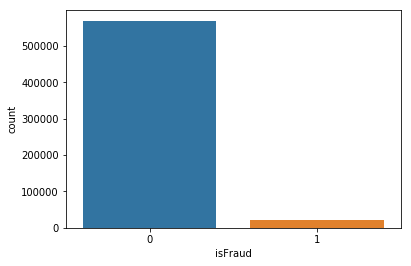

In [10]:
sns.countplot(df_train['isFraud'])

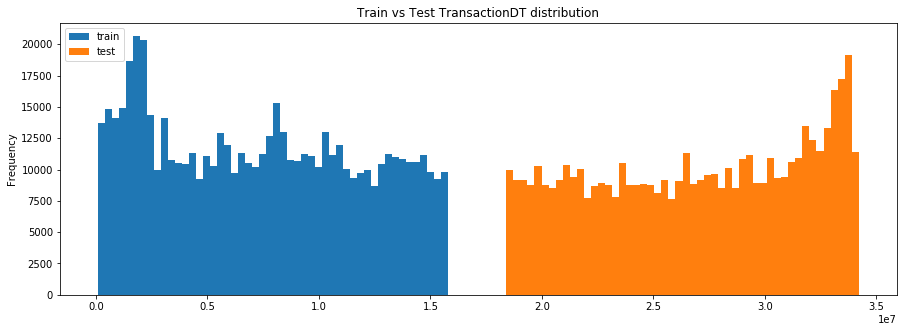

In [11]:
df_train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
df_test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

Product feature

Text(0.5, 1.0, 'ProductCD with Fraud')

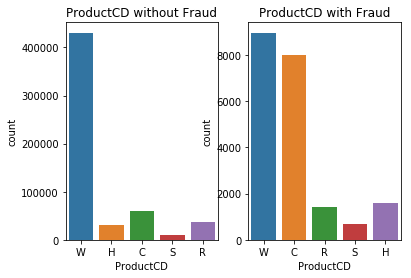

In [12]:
f, axes = plt.subplots(1, 2)
sns.countplot(df_train.loc[df_train['isFraud'] == 0]['ProductCD'], ax=axes[0]).set_title('ProductCD without Fraud')
sns.countplot(df_train.loc[df_train['isFraud'] == 1]['ProductCD'], ax=axes[1]).set_title('ProductCD with Fraud')

Card features

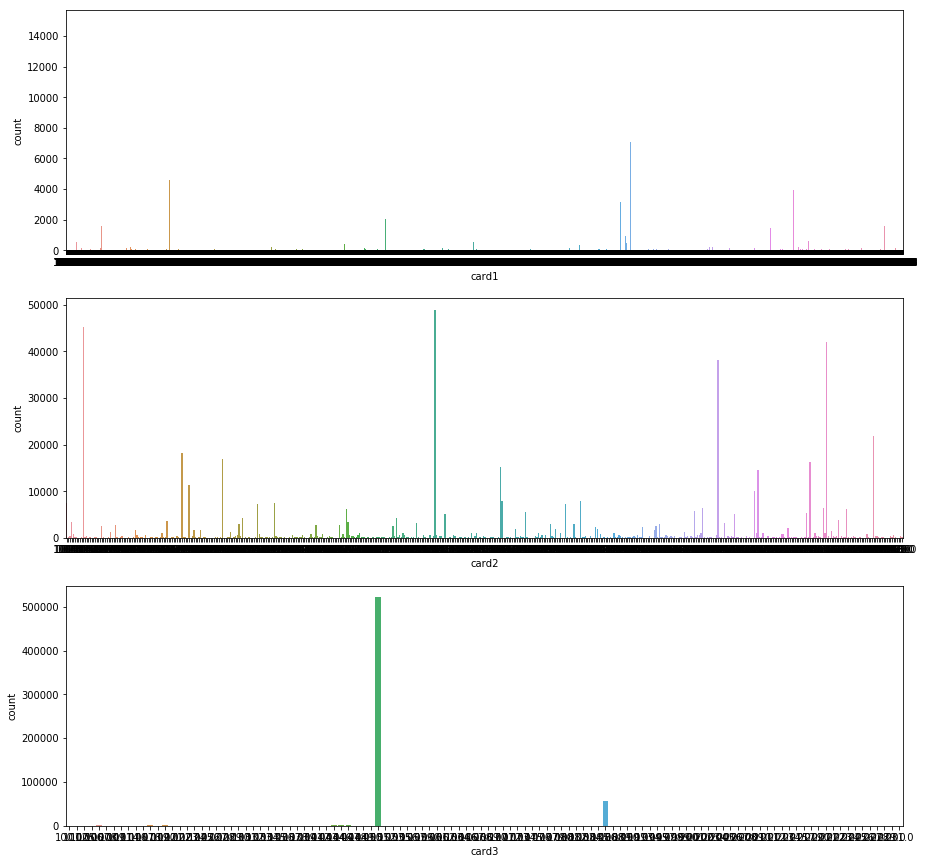

In [15]:
f, ax = plt.subplots(3, figsize=(15,15))
sns.countplot(df_train['card1'], ax=ax[0])
sns.countplot(df_train['card2'], ax=ax[1])
sns.countplot(df_train['card3'], ax=ax[2])


Card features pt.2

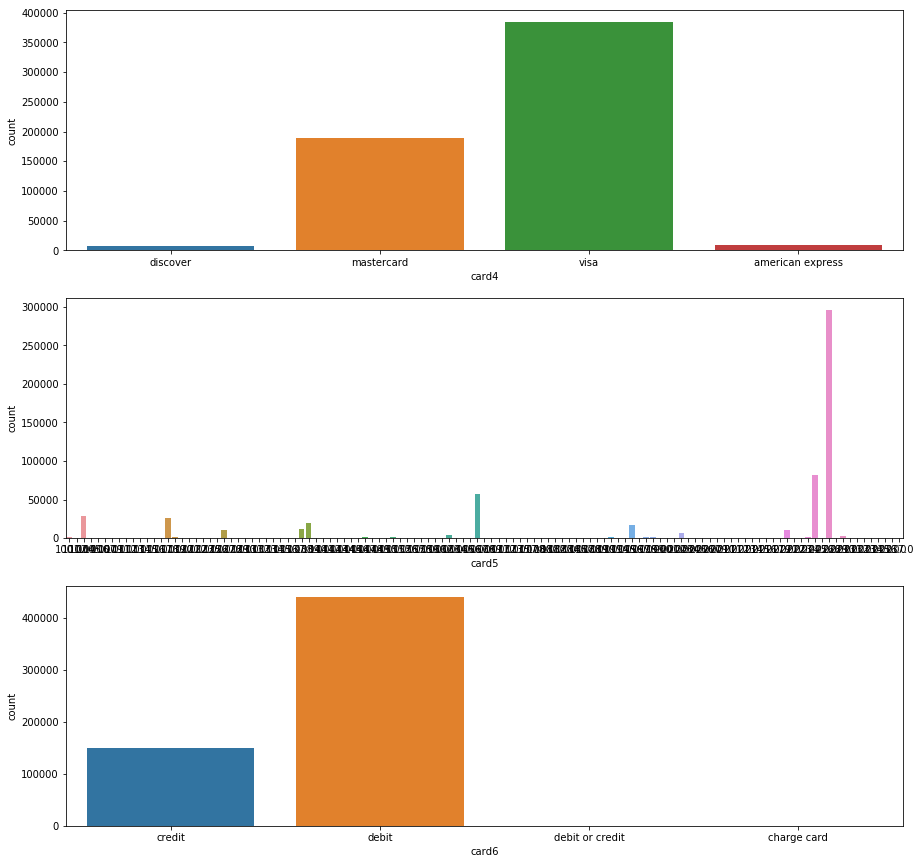

In [16]:
f, ax = plt.subplots(3, figsize=(15,15))
sns.countplot(df_train['card4'], ax=ax[0])
sns.countplot(df_train['card5'], ax=ax[1])
sns.countplot(df_train['card6'], ax=ax[2])

Address features

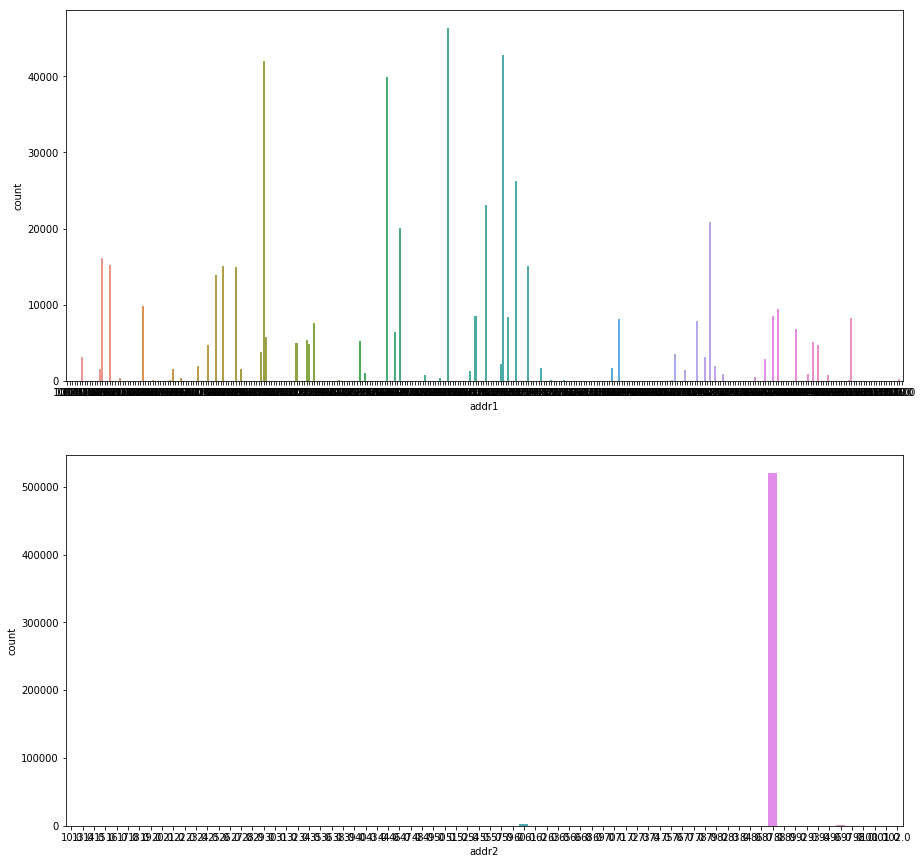

In [17]:
f, ax = plt.subplots(2, figsize=(15,15))
sns.countplot(df_train['addr1'], ax=ax[0])
sns.countplot(df_train['addr2'], ax=ax[1])

Purchaser and recipient e-mail domain

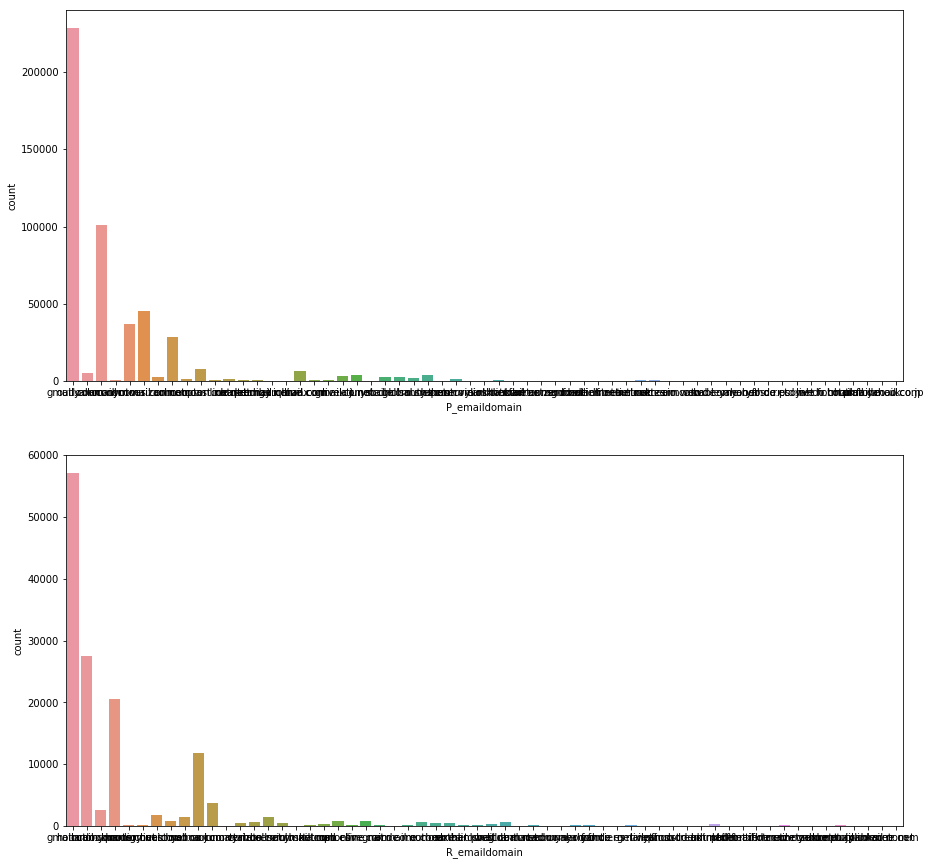

In [18]:
f, ax = plt.subplots(2, figsize=(15,15))

sns.countplot(df_train['P_emaildomain'], ax=ax[0])
sns.countplot(df_train['R_emaildomain'], ax=ax[1])

C features (counting, such as how many addresses are found to be associated with)

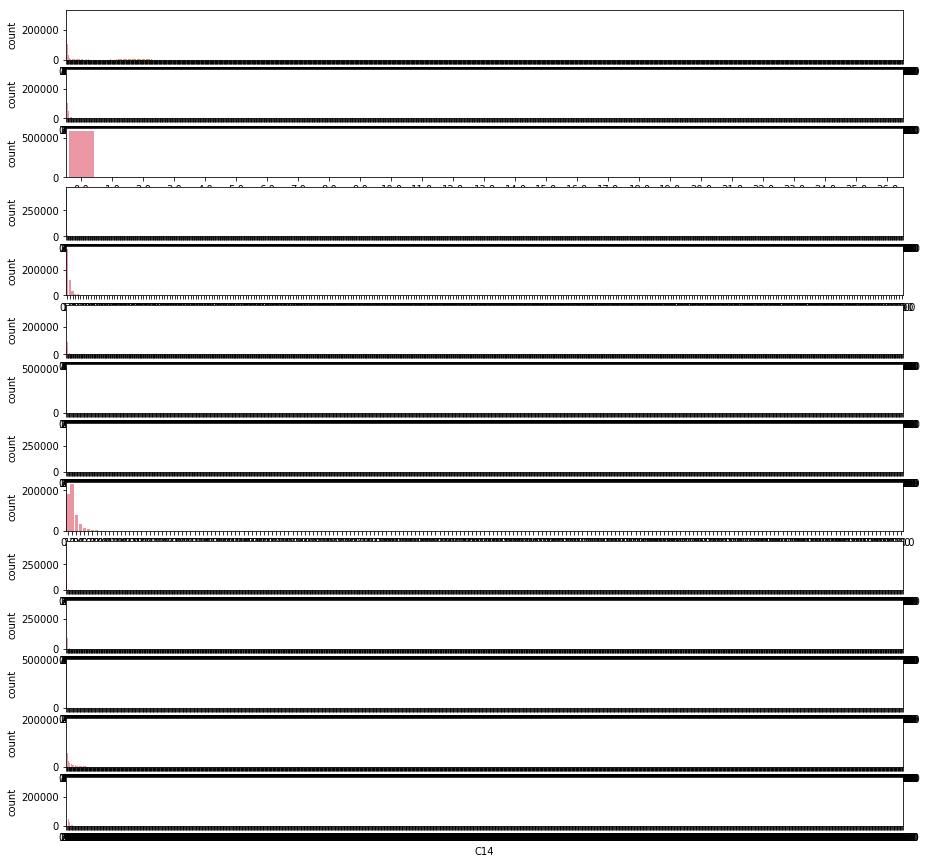

In [21]:
f, ax = plt.subplots(14, figsize=(15,15))
sns.countplot(df_train['C1'], ax=ax[0])
sns.countplot(df_train['C2'], ax=ax[1])
sns.countplot(df_train['C3'], ax=ax[2])
sns.countplot(df_train['C4'], ax=ax[3])
sns.countplot(df_train['C5'], ax=ax[4])
sns.countplot(df_train['C6'], ax=ax[5])
sns.countplot(df_train['C7'], ax=ax[6])
sns.countplot(df_train['C8'], ax=ax[7])
sns.countplot(df_train['C9'], ax=ax[8])
sns.countplot(df_train['C10'], ax=ax[9])
sns.countplot(df_train['C11'], ax=ax[10])
sns.countplot(df_train['C12'], ax=ax[11])
sns.countplot(df_train['C13'], ax=ax[12])
sns.countplot(df_train['C14'], ax=ax[13])

M features (match, such as names on card and address, etc)

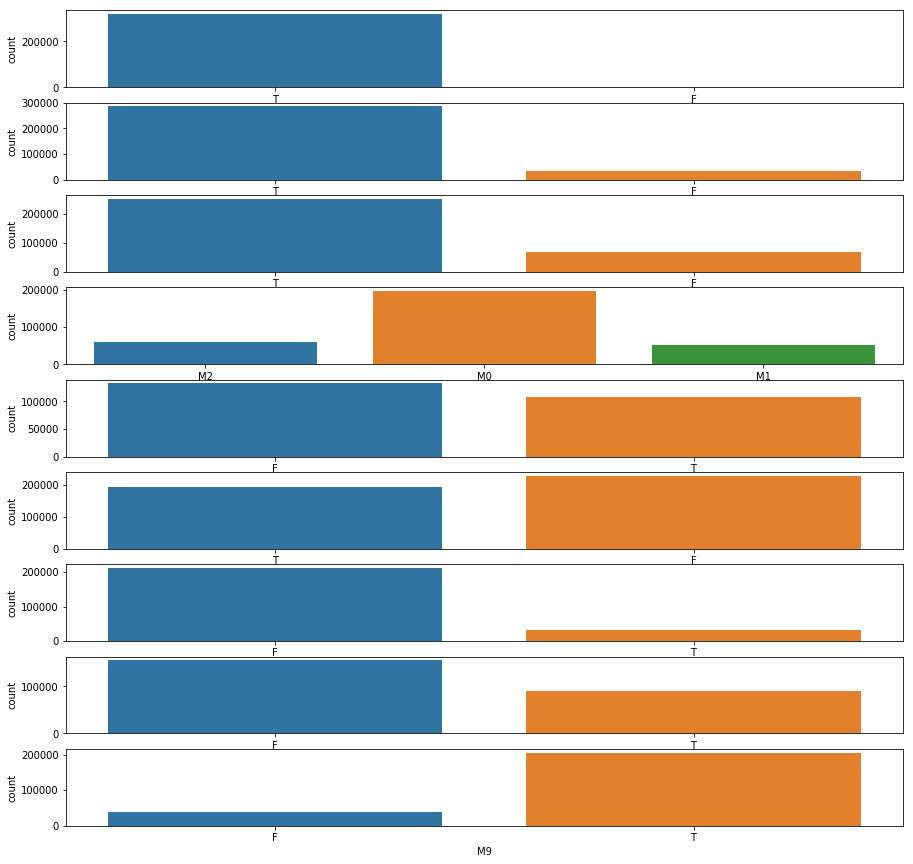

In [20]:
f, ax = plt.subplots(9, figsize=(15,15))
sns.countplot(df_train['M1'], ax=ax[0])
sns.countplot(df_train['M2'], ax=ax[1])
sns.countplot(df_train['M3'], ax=ax[2])
sns.countplot(df_train['M4'], ax=ax[3])
sns.countplot(df_train['M5'], ax=ax[4])
sns.countplot(df_train['M6'], ax=ax[5])
sns.countplot(df_train['M7'], ax=ax[6])
sns.countplot(df_train['M8'], ax=ax[7])
sns.countplot(df_train['M9'], ax=ax[8])

D features (time deltas)

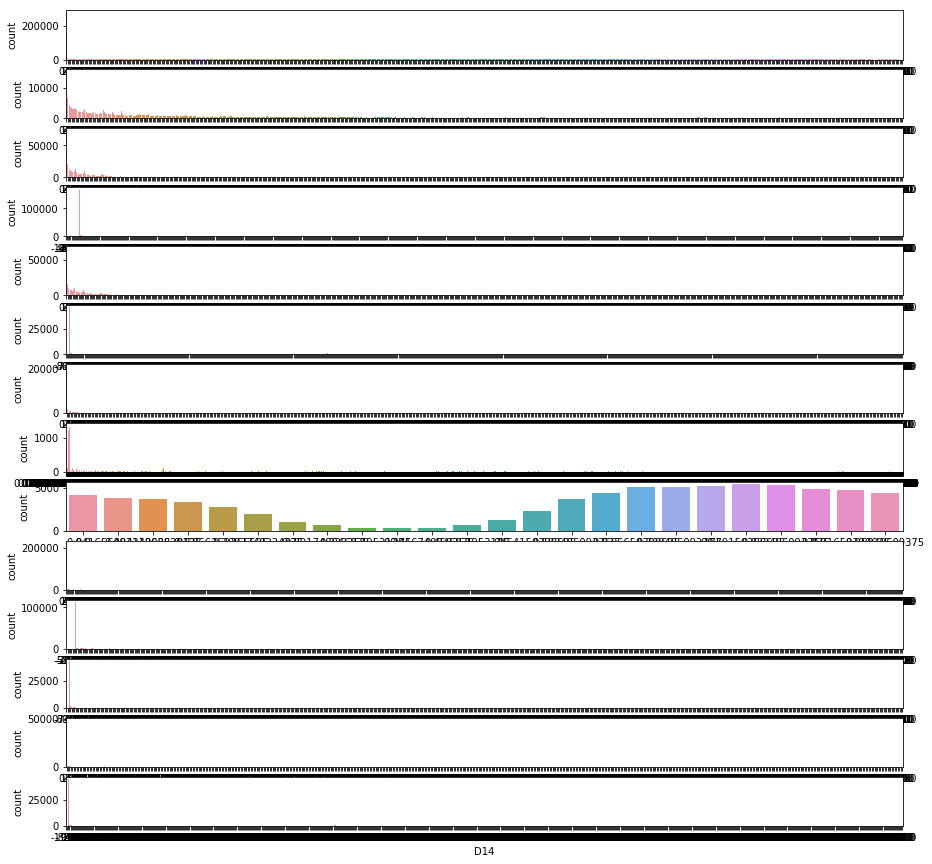

In [22]:
f, ax = plt.subplots(14, figsize=(15,15))
sns.countplot(df_train['D1'], ax=ax[0])
sns.countplot(df_train['D2'], ax=ax[1])
sns.countplot(df_train['D3'], ax=ax[2])
sns.countplot(df_train['D4'], ax=ax[3])
sns.countplot(df_train['D5'], ax=ax[4])
sns.countplot(df_train['D6'], ax=ax[5])
sns.countplot(df_train['D7'], ax=ax[6])
sns.countplot(df_train['D8'], ax=ax[7])
sns.countplot(df_train['D9'], ax=ax[8])
sns.countplot(df_train['D10'], ax=ax[9])
sns.countplot(df_train['D11'], ax=ax[10])
sns.countplot(df_train['D12'], ax=ax[11])
sns.countplot(df_train['D13'], ax=ax[12])
sns.countplot(df_train['D14'], ax=ax[13])

DeviceType and DeviceInfo

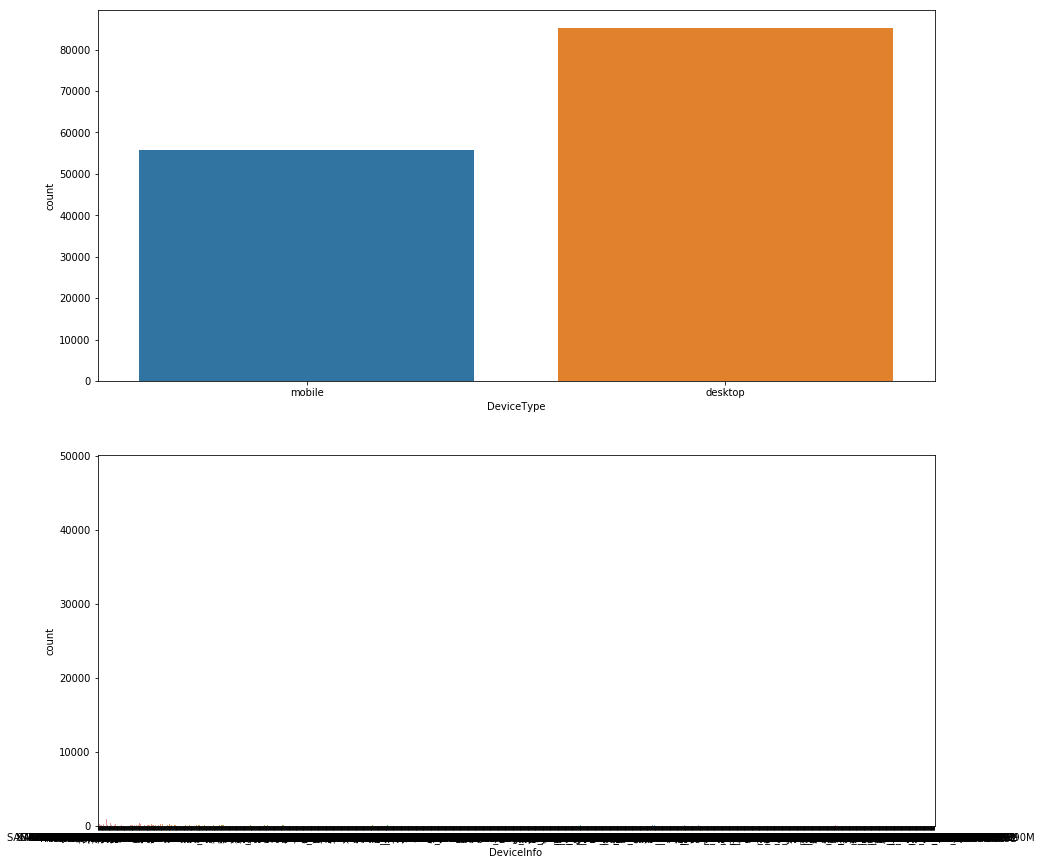

In [25]:
f, ax = plt.subplots(2, figsize=(15,15))
sns.countplot(df_train['DeviceType'], ax=ax[0])
sns.countplot(df_train['DeviceInfo'], ax=ax[1])